# Introduction to the LaSSynth, Lattice Surgery Subroutine Synthesizer

## Prerequisites


This Jupyter notebook aims at giving a minimal demo on how to use this software.
The reader needs to know how lattice surgery works to fully understand this notebook.
The most direct reference is [our paper](http://arxiv.org/abs/2404.18369) which, in itself, also provides more pointers to background knowledge references.
There are two we would like to mention here.
- [arXiv:1704.08670](https://arxiv.org/abs/1704.08670) links merging and spliting operations in lattice surgery to ZX calculus.
We leverage this connection a lot in our software.
- [arXiv:1808.02892](https://arxiv.org/abs/1808.02892) is helpful because it works through some examples of composing lattice surgery operations to perform quantum computation.

## Introduction


In what follows, we are assuming a surface code quantum memory with nearest-neighbor connectivity among the qubits (in both the physical and the logical sense).
We perform fault-tolerant quantum computing with lattice surgery between patches of physical qubits.
Some of these patches correspond to logical qubits whereas others can be temporary ancilla during computation.

Since the logical qubits are in a 2D grid, and there is the time dimension, the compilation problem is laying out operations in a 3D grid to realize certain computation.
We consider only a bounded spacetime and what *can* be realized within the bounds is called a *lattice surgery subroutine* (LaS), because it should be considered as a subroutine in the whole quantum algorithm.

Because of the connection between lattice surgery and ZX calculus, a LaS can be seen as a ZX diagram with nodes at points in a 3D grid and edges only between nearest neighbors, as seen in the figure below.
If you have worked with ZX calculus, you would know that this ZX diagram is a CNOT.
However, it seems that there are two "unnecessary" identity nodes in the middle.
This is because there are other constraints when it comes to realizing the CNOT in a surface code memory.
Our representation of a LaS, the "pipe diagram" below, does account for these extra constraints.

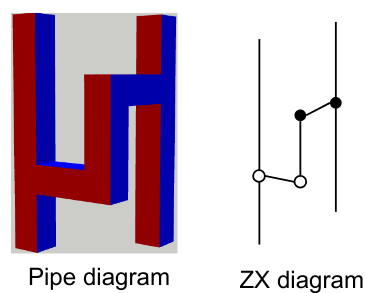

## Pipe diagrams



We use a 3D coordinate system with basis I, J, and K.
We avoid using X, Y, and Z because these letters are also used in ZX calculus for different purposes.
K is the time dimension while I and J are the space dimensions.

If we want the pipe diagram to look like exactly what happens on chip, we need to draw them in scale, e.g, shown on the right below.
There are four patches of surface codes, and only three are used in the computation.
These three are identified by their coordinates in the I-J plane: (1,0), (1,1), and (0,1) from left to right in the picture.
Between the patches, there are some "gaps" which are lines on physical qubits.
We can perform merging and splitting of patches with these gaps.
Since the gap is very narrow compared to the patches, but what happens there are really what decides the computation.
Thus, to see these merging and splitting more clearly, we often stretch the gaps in the pipe diagram, resulting in something like the picture on the left below.

The unit in all three dimension is the code distance.
So, a patch going through a full QEC cycle will become a cube.
These cubes are sitting at integer points in the I-J-K grid.
Nontrivial logical operations are done by connecting these cubes with pipes.
For example, two cubes connected in the I-J plane correspond to performing merging and splitting of two patches; a cube that has a vertical connection below but not above is a logical measurement; etc.
At this point, we see that the problem of compiling LaS is laying out these cubes and pipes in a limited spacetime.

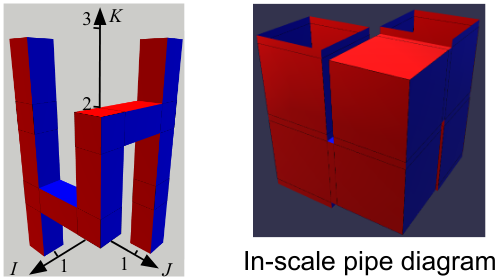

## LaS Specification

There are some constraints in the construction of these diagrams, e.g., matching colors at intersection of two pipes, but we are not going to introduce them here.
After all, the purpose of a synthesizer is to let a computer consider those constraints instead of humans.
The reader can refer to our paper, or even to the code in this repo for these constraints later on.
What we are going to detail now is how to specify a problem to the compiler, so that the reader can start using the software.

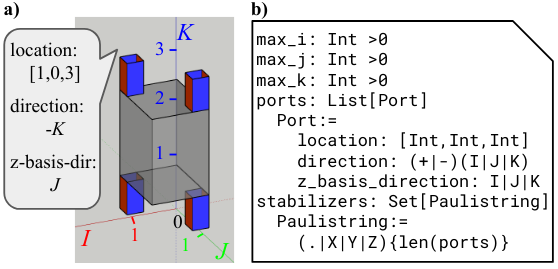

The LaS specification is shown in part b) of the figure above.
`max_i`, `max_j` and `max_k` are the bounds of spacetime.
In our example, they are 2, 2, and 3, which means all the cubes and pipes are within 2x2x3 volume.

In [10]:
input_dict = {
  "max_i": 2, "max_j": 2, "max_k": 3
}

There are certain *ports* that connects the LaS to the outside (which makes sense since a subroutine in classical computing always has some arguements and some returns).
In this example, there are two ports on the bottom floor corresponding to the two qubits before the CNOT; then, there is some manipulation of these two qubits implmented with the pipes in the gray box; on the top floor, the two ports are the qubits after going through the CNOT.

We need to provide three things to specify each port.
Let us look at the port for the output of control qubit in the CNOT indicated in the callout in part a) of the figure above.
In the code block below, it is the third port in `input_dict["ports"]`.
- Its `location` is `[1,0,3]` because that is where the information is going out of the LSS.
- In general, the pipe connecting a port can also be in I, J or K direction.
Additionally, we need another character (`-` or `+`) to indicate the direction from the port to the other parts of the LaS.
In this example, the pipe is in the K direction, and we need to go downward from `[1, 0, 3]` to everything else, so the `direction` of the port is `-K`.
- Finally, surface code patches have a space orientation of the X and Z boundaries indicated by red and blue above.
We provide which one of I, J, and K is orthogonal to the face of Z boundary (blue).
In this example, it is J that is orthogonal to the blue faces, so the `z_basis_direction` of this port is `J`.

In [11]:
input_dict["ports"] = [
    {"location": [1, 0, 0], "direction": "+K", "z_basis_direction": "J"},
    {"location": [0, 1, 0], "direction": "+K", "z_basis_direction": "J"},
    {"location": [1, 0, 3], "direction": "-K", "z_basis_direction": "J"},
    {"location": [0, 1, 3], "direction": "-K", "z_basis_direction": "J"},
]

Finally, we need to provide the stabilizer constraints on the ports to ensure that the LaS indeed realizes the logical operations we want to perform.
Although intuitively there are input and output ports for the CNOT, in a LaS, there is no inherent distinction between inputs and outputs.
What matters is that the given stabilizers have to match the ordering of the ports.
Our ordering is (control qubit input, target qubit input, control qubit output, target qubit output), so the correct stabilizers are ZIZI, IZZZ, XIXX, and IXIX.
If we change the ordering of the `"ports"` list above, we also need to change the stabilizers.

In [12]:
input_dict["stabilizers"] = ["Z.Z.", ".ZZZ", "X.XX", ".X.X"]
# Note that we use a . for an identity in a stabilizer

## Solving LaS

By now we have finished preparing the specification of the LaS.
We can use our software package `lassynth`, specifically the class `LatticeSurgerySynthesizer` to solve the problem.
When we invoke `solve` method, the synthesizer gives us a solution with respect to a `specification`.

In [13]:
from lassynth import LatticeSurgerySynthesizer

las_synth = LatticeSurgerySynthesizer()
result = las_synth.solve(specification=input_dict)
result

As you have noticed, the return value is of a class `LatticeSurgerySolution`.
We implement a few methods for this class to help us further manipulate the solution.
To see the "raw" solution, i.e., LaSRe (lattice surgery subroutine representation) in the paper, you can access the `lasre` of this result.
Due to technical reasons, the `ports` here is another encoding compared to the `ports` in the specification.
Intersted readers can refer to comments in the code to understand this encoding, but it is not too important in this notebook.

In [14]:
result.lasre

{'n_i': 2,
 'n_j': 2,
 'n_k': 3,
 'n_p': 4,
 'n_s': 4,
 'ports': [{'i': 1, 'j': 0, 'k': 0, 'd': 'K', 'e': '-', 'c': 1},
  {'i': 0, 'j': 1, 'k': 0, 'd': 'K', 'e': '-', 'c': 1},
  {'i': 1, 'j': 0, 'k': 2, 'd': 'K', 'e': '+', 'c': 1},
  {'i': 0, 'j': 1, 'k': 2, 'd': 'K', 'e': '+', 'c': 1}],
 'stabs': [[{'KI': 0, 'KJ': 1},
   {'KI': 0, 'KJ': 0},
   {'KI': 0, 'KJ': 1},
   {'KI': 0, 'KJ': 0}],
  [{'KI': 0, 'KJ': 0},
   {'KI': 0, 'KJ': 1},
   {'KI': 0, 'KJ': 1},
   {'KI': 0, 'KJ': 1}],
  [{'KI': 1, 'KJ': 0},
   {'KI': 0, 'KJ': 0},
   {'KI': 1, 'KJ': 0},
   {'KI': 1, 'KJ': 0}],
  [{'KI': 0, 'KJ': 0},
   {'KI': 1, 'KJ': 0},
   {'KI': 0, 'KJ': 0},
   {'KI': 1, 'KJ': 0}]],
 'port_cubes': [(1, 0, 0), (0, 1, 0), (1, 0, 3), (0, 1, 3)],
 'optional': {},
 'ExistI': [[[0, 1, 0], [0, 1, 0]], [[0, 0, 0], [0, 0, 0]]],
 'ExistJ': [[[0, 0, 1], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]]],
 'ExistK': [[[0, 1, 0], [1, 1, 1]], [[1, 1, 1], [1, 1, 0]]],
 'ColorI': [[[0, 1, 1], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]]],
 'Color

## Post-process and Output LaS

We provide a few rewrite passes to remove valid but unnecessary structures in the solution, and also color the K-pipes.
These can be applied with the follow call. 

In [15]:
result = result.after_default_optimizations()

We can export the result to a few formats.
The most direct one is to save the LaSRe, which is now just a dictionary

In [16]:
result.save_lasre("cnot.lasre.json")

We can also create a 3D modelling file in the [GLTF](https://www.khronos.org/gltf/) format.
This can be opened in many software, a lot of them are also web-based.
The `attach_axes` flag attaches I (red), J (green), and K (blue) axis to the GLTF.

In [17]:
result.to_3d_model_gltf("cnot.gltf", attach_axes=True)

Like mentioned previously, the generated LaS can be easily mapped to a ZX-diagram.
We can use this connection to verify our result.
Internally, we construct the ZX-diagram and let [Stim ZX](https://github.com/quantumlib/Stim/tree/main/glue/zx) to derive the stabilizers.
Then, we check whether these stabilizers are commutable with the ones in the specification.
If all are commutable, then our LaS is correct.

In [18]:
result.verify_stabilizers_stimzx(specification=input_dict, print_stabilizers=True)

specified:
+Z_Z_
+_ZZZ
+X_XX
+_X_X
resulting:
+X_XX
+Z_Z_
+_X_X
+_ZZZ
specified and resulting stabilizers are equivalent.


True

## Using Other SAT solver

So far, we are using the [Z3 SMT solver](https://github.com/Z3Prover/z3) to do everything.
In our experience, it may be faster to generate an SAT problem with Z3 and solve it using other solvers, like Kissat.
For the user, it is very easy to change: just initiate the `LatticeSurgerySynthesizer` with the directory where Kissat is installed in your system.

In [19]:
las_synth = LatticeSurgerySynthesizer(solver="kissat", kissat_dir="")
# you need to add the kissat dir based on where kissat is on your computer

In [20]:
result = las_synth.solve(
    specification=input_dict,
    print_detail=True,
    dimacs_file_name="cnot",
    sat_log_file_name="cnot"
)

Adding constraints time: 0.207474946975708
CNF generation time: 0.004982948303222656
c ---- [ banner ] ------------------------------------------------------------
c
c Kissat SAT Solver
c 
c Copyright (c) 2021-2023 Armin Biere University of Freiburg
c Copyright (c) 2019-2021 Armin Biere Johannes Kepler University Linz
c 
c Version 3.1.1 71caafb4d182ced9f76cef45b00f37cc598f2a37
c Apple clang version 15.0.0 (clang-1500.3.9.4) -W -Wall -O3 -DNDEBUG
c Sun May 12 13:03:10 PDT 2024 Darwin MacBook-Pro-2 23.4.0 arm64
c
c ---- [ parsing ] -----------------------------------------------------------
c
c opened and reading DIMACS file:
c
c   cnot.dimacs
c
c parsed 'p cnf 462 2231' header
c closing input after reading 40739 bytes (40 KB)
c finished parsing after 0.00 seconds
c
c ---- [ options ] -----------------------------------------------------------
c
c --seed=916189                    (different from default '0')
c
c ---- [ solving ] -----------------------------------------------------------

We used a few optional arguments above.
`print_detail` will display the output of Kissat on the screen. 
`dimacs_file_name` specifies where to store the SAT problem instance in the DIMACS format.
This instance is generated by Z3 and then solved by Kissat.
`sat_log_file_name` saves the output of Kissat, which is basically what you have seen as the output (from `c ---- [ banner ]` to `c exit 10`).